# **PCA-SIFT**

### Import Libraries and Images

In [1]:
import cv2
import numpy as np
import matplotlib as plt
import numpy as np
from google.colab.patches import cv2_imshow


In [3]:
img1 = cv2.imread('/content/img1.png')
img2 = cv2.imread('/content/img2.png')

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

img1_cl = cv2.imread('/content/img1.png')
img2_cl = cv2.imread('/content/img2.png')

### Functions for Image transformations

In [4]:
def gaussian_blur(image, sigma ,kernel_size = (5,5)):
    blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)
    return blurred_image

In [5]:
def rotate_image(image, angle, direction='clockwise'):
    if direction == 'anticlockwise':
        angle = -angle
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

In [6]:
def scale_image(image, scaling_factor):
    height, width = image.shape[:2]
    new_height = int(height * scaling_factor)
    new_width = int(width * scaling_factor)
    scaled_image = cv2.resize(image, (new_width, new_height))
    return scaled_image

### Constants

In [7]:
SIGMA = 0.4
SAMPLE_RATE = 2
OCTAVE_DIMENSION = 6
THRESHOLD = 0.001

HEIGHT1 = img1.shape[0]
WIDTH1 = img1.shape[1]

HEIGHT2 = img2.shape[0]
WIDTH2 = img2.shape[1]


### Helper Functions

In [8]:
def gaussian_filter(sigma = SIGMA , size = 3):
    filter = np.exp(-np.arange(-(size-1)//2, (size-1)//2 + 1)**2 / (2 * sigma**2))
    filter /= filter.sum()
    filter_2d = np.outer(filter, filter)
    return filter_2d

In [9]:
def scale_space (image ,sigma, filter_size = 3):
  gaussian = gaussian_filter(sigma,filter_size)
  result = cv2.filter2D(image.astype(float), -1, gaussian, borderType=cv2.BORDER_REPLICATE) #convolution
  return result

In [10]:
def DOG(IMG,k,sigma,size = 3):
  result = scale_space(IMG,(k*sigma),size) - scale_space(IMG,sigma,size)
  return result

In [11]:
def get_downsampled_image(image, sample_rate=SAMPLE_RATE):
    sample = image[0::sample_rate, 0::sample_rate]
    return sample

### Class of Feature and Octave

In [12]:
class SIFTfeature():
  def __init__(self,location,scale = None,orientation = None, descriptor = None):
    self.location = location
    self.scale = scale
    self.orientation = orientation
    self.descriptor = descriptor

In [13]:
class octave():
  def __init__ (self,IMG,sigma,sample,no_of_images=OCTAVE_DIMENSION):
    self.count = no_of_images
    self.sample = sample
    self.sigma = sigma * self.sample
    self.img = get_downsampled_image(IMG , sample)

  def create_DOG(self):
    DOG_array = []
    for i in range(self.count - 1):
      k = 2**(i+1/self.count)
      temp = DOG(self.img, k, self.sigma)
      DOG_array.append(temp)
    return DOG_array

### 1. Scale space extrema Detection

Helper Functions

In [14]:
def is_local_min(arr, x, y, threshold):
    point_value = arr[y, x]
    neighbors_values = [
        arr[y-1, x-1], arr[y-1, x], arr[y-1, x+1],
        arr[y, x-1], arr[y, x+1],
        arr[y+1, x-1], arr[y+1, x], arr[y+1, x+1]]
    return all(neighbor_value - point_value > threshold for neighbor_value in neighbors_values)

def is_local_max(arr, x, y, threshold):
    point_value = arr[y, x]
    neighbors_values = [
        arr[y-1, x-1], arr[y-1, x], arr[y-1, x+1],
        arr[y, x-1], arr[y, x+1],
        arr[y+1, x-1], arr[y+1, x], arr[y+1, x+1]]
    return all(point_value - neighbor_value > threshold for neighbor_value in neighbors_values)

In [15]:
def is_maxima(x,y, arr0 , arr1 , arr2 , threshold):
    if (arr1[y,x] - arr0[y,x]  > threshold) and (arr1[y,x]  - arr2[y,x]  > threshold):
      result1 = is_local_max(arr1, x, y ,threshold)
      if result1 == True:
        result0 = is_local_max(arr0, x, y ,threshold)
        if result0 == True:
          result2 = is_local_max(arr2, x, y ,threshold)
          if result2 == True:
            return True
          else: return False
        else: return False
      else: return False

def is_minima(x,y, arr0 , arr1 , arr2 , threshold):
    if (arr0[y,x] - arr1[y,x]  > threshold) and (arr2[y,x]  - arr1[y,x]  > threshold):
      result1 = is_local_min(arr1, x, y ,threshold)
      if result1 == True:
        result0 = is_local_min(arr0, x, y ,threshold)
        if result0 == True:
          result2 = is_local_min(arr2, x, y ,threshold)
          if result2 == True:
            return True
          else: return False
        else: return False
      else: return False

In [16]:
def iskeypoint(x,y , arr0 , arr1 , arr2 , threshold = 0.0001):
    temp1 = is_maxima(x,y , arr0 , arr1 , arr2 , threshold)
    temp2 = is_minima(x,y, arr0 , arr1 , arr2 , threshold)
    if temp1 == True or temp2 == True:
      return True
    else: return False

Creating DOGs

In [17]:
def create_oct_DOG(image):
  octave_A = octave(image,SIGMA,1)
  octave_B = octave(image,SIGMA,2)
  dogarr_A = octave_A.create_DOG()
  dogarr_B = octave_B.create_DOG()
  oct_dog_arr = [dogarr_A,dogarr_B]
  return oct_dog_arr

Finding Scale Space Extremas for each octave

In [18]:
def find_scale_space_extremas(image, array , thresh):
  oct_keypoint_Arr = []
  H = image.shape[0]
  W = image.shape[1]

  for t in range(len(array)):
    height = int(H/(2**t))
    width = int(W/(2**t))
    keypoint_arr = []
    dogarr = array[t]

    for i in range(1,4):
      for j in range(1,height-1):
        for k in range(1,width-1):
          temp = iskeypoint(k,j,dogarr[i-1], dogarr[i] , dogarr[i+1] , thresh)

          if temp == True:
            temp2 = SIFTfeature((j,k),i)
            keypoint_arr.append(temp2)
    oct_keypoint_Arr.append(keypoint_arr)

  return oct_keypoint_Arr

### 3. Orientation Assignment

Compute orientation for keypoint

In [19]:
def compute_orientation(image, point):
    patch_size =25
    (x, y) = point
    if x - patch_size // 2 < 0 or x + patch_size // 2 >= image.shape[1] or y - patch_size // 2 < 0 or y + patch_size // 2 >= image.shape[0]:
        return 180

    patch = image[y - patch_size // 2:y + patch_size // 2 + 1, x - patch_size // 2:x + patch_size // 2 + 1]

    gradient_x = cv2.Sobel(patch, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(patch, cv2.CV_64F, 0, 1, ksize=3)

    gradient_phase = np.arctan2(gradient_y, gradient_x) * (180.0 / np.pi)

    gradient_phase_flat = gradient_phase.flatten()
    histogram, bin_edges = np.histogram(gradient_phase_flat, bins=np.arange(-180, 181, 10))
    orientation_bin = np.argmax(histogram)
    orientation_degrees = orientation_bin * 10 - 180

    return orientation_degrees

Set orientations for keypoints

In [20]:
def assign_orientation(array,image):
  for i , arr in enumerate(array):
    for obj in arr:
      obj.orientation = compute_orientation(image,obj.location)

### 4. Descriptor Representation

Compute Descriptor Vector for Keypoints

In [21]:
def descriptor(image, point):
    patch_size = 39
    (x, y) = point
    if x - patch_size // 2 < 0 or x + patch_size // 2 >= image.shape[1] or y - patch_size // 2 < 0 or y + patch_size // 2 >= image.shape[0]:

        return np.zeros((39*39))

    patch = image[y - patch_size // 2:y + patch_size // 2 + 1, x - patch_size // 2:x + patch_size // 2 + 1]

    gradient_x = cv2.Sobel(patch, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(patch, cv2.CV_64F, 0, 1, ksize=3)

    descriptor = np.concatenate([gradient_x.flatten(), gradient_y.flatten()])


    return descriptor

Set description for keypoints

In [22]:
def assign_descriptors(array,image):
   for i , arr in enumerate(array):
    for obj in arr:
      obj.descriptor = descriptor(image,obj.location)

### 5 . Display Keypoints

In [23]:
def display_keypoints(image,array,ocatave=False):
  for i , arr in enumerate(array):
    temp = image
    temp = scale_image(temp,1/(i+1))
    for obj in arr:

        (x, y) = obj.location
        scale = int(obj.scale)
        angle = obj.orientation
        radius = scale * 10

        center = (int(y), int(x))
        cv2.circle(temp, center, radius=radius, color=(0, 0, 0), thickness= 1)

        arrow_length = radius
        end_point = (int(y + arrow_length * np.sin(np.radians(angle))),
                  int(x - arrow_length * np.cos(np.radians(angle))))

        cv2.circle(temp, center, radius=radius, color=(0, 0, 0), thickness=1)
        cv2.arrowedLine(temp, center, end_point, color=(0, 255, 0), thickness=2, tipLength=0.5)

    cv2_imshow(temp)
    if (octave == False):
      break


# `MAIN FUNCTION`

**image:** input image on which PCA is to be done \\
**thresh:** threshold for creating DOG's (default:0; greater the thresh, lesser the no. of keypoints) \\

In [24]:
#returns a list of keypoint objects
def PCA_SIFT(image,thresh=0):
  oct_dog_arr = create_oct_DOG(image)
  oct_keypoint_Arr = find_scale_space_extremas(image,oct_dog_arr,thresh)
  assign_orientation(oct_keypoint_Arr,image)
  assign_descriptors(oct_keypoint_Arr,image)
  return oct_keypoint_Arr

#`RESULTS`

## **Image 1**

### Standard

In [25]:
keypoints = PCA_SIFT(img1,0)
print(f'Image : 1')
print(f'Transformation:None')
print(f'The number of Keypoints in 1st octave is {len(keypoints[0])}')
print(f'The number of Keypoints in 2nd octave is {len(keypoints[1])}')

Image : 1
Transformation:None
The number of Keypoints in 1st octave is 8196
The number of Keypoints in 2nd octave is 501


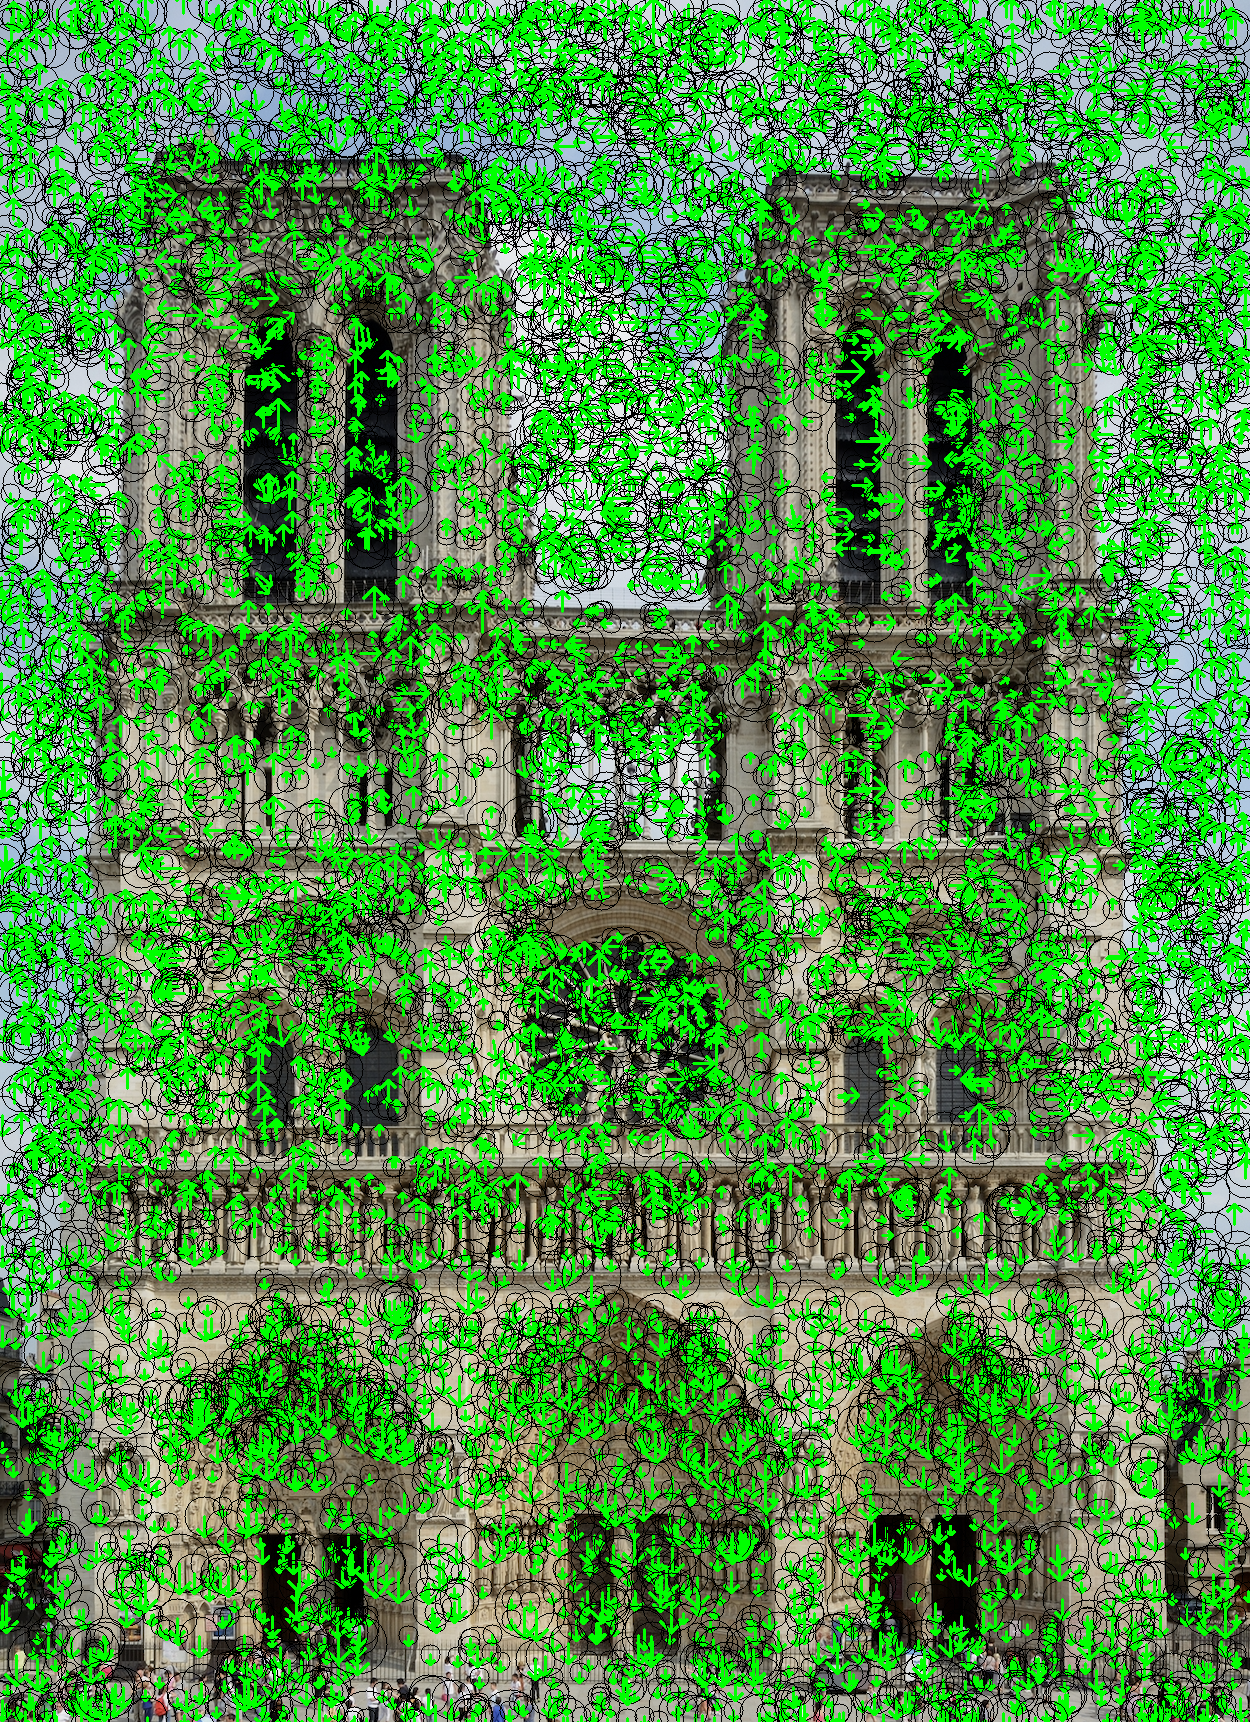

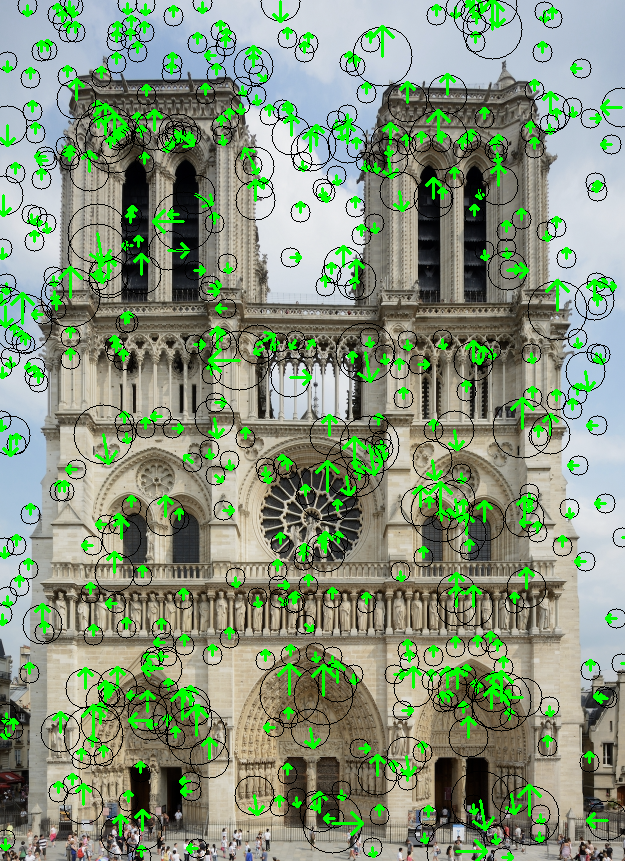

In [26]:
display_keypoints(img1_cl,keypoints)

### Rotation

In [ ]:
angle = [30,45,60]
print(f'Image : 1\n\n')
for i,angle in enumerate(angle):
  print(f'Transformation: Rotation {angle} degrees')
  tempimg = rotate_image(img1,angle)
  tempkey = PCA_SIFT(tempimg,0.0001)
  print(f'The number of Keypoints in 1st octave is {len(tempkey[0])}')
  print(f'The number of Keypoints in 2nd octave is {len(tempkey[1])}')
  print('\n')


Image : 1


Transformation: Rotation 30 degrees
The number of Keypoints in 1st octave is 8003
The number of Keypoints in 2nd octave is 511


Transformation: Rotation 45 degrees
The number of Keypoints in 1st octave is 7690
The number of Keypoints in 2nd octave is 771


Transformation: Rotation 60 degrees
The number of Keypoints in 1st octave is 7632
The number of Keypoints in 2nd octave is 499




### Scaling

In [ ]:
angle = [1.25,1.5,2]
print(f'Image : 1\n\n')
for i,scale in enumerate(angle):
  print(f'Transformation: Scaling by {scale}')
  tempimg = scale_image(img1,scale)
  tempkey = PCA_SIFT(tempimg)
  print(f'The number of Keypoints in 1st octave is {len(tempkey[0])}')
  print(f'The number of Keypoints in 2nd octave is {len(tempkey[1])}')
  print('\n')

Image : 1


Transformation: Scaling by 1.25
The number of Keypoints in 1st octave is 7734
The number of Keypoints in 2nd octave is 546


Transformation: Scaling by 1.5
The number of Keypoints in 1st octave is 12233
The number of Keypoints in 2nd octave is 636


Transformation: Scaling by 2
The number of Keypoints in 1st octave is 26671
The number of Keypoints in 2nd octave is 785




### Gaussian Blur

In [ ]:
sigma = [4,16,64]
print(f'Image : 1\n\n')
for i,sig in enumerate(sigma):
  print(f'Transformation: Gaussian blur, sigma = {sig}')
  tempimg = gaussian_blur(img1,sig)
  tempkey = PCA_SIFT(tempimg)
  print(f'The number of Keypoints in 1st octave is {len(tempkey[0])}')
  print(f'The number of Keypoints in 2nd octave is {len(tempkey[1])}')
  print('\n')

Image : 1


Transformation: Gaussian blur, sigma = 4
The number of Keypoints in 1st octave is 6595
The number of Keypoints in 2nd octave is 245


Transformation: Gaussian blur, sigma = 16
The number of Keypoints in 1st octave is 6154
The number of Keypoints in 2nd octave is 265


Transformation: Gaussian blur, sigma = 64
The number of Keypoints in 1st octave is 6154
The number of Keypoints in 2nd octave is 265




## **Image 2**

### Standard

In [ ]:
keypoints = PCA_SIFT(img2)
print(f'Image : 2')
print(f'Transformation:None')
print(f'The number of Keypoints in 1st octave is {len(keypoints[0])}')
print(f'The number of Keypoints in 1st octave is {len(keypoints[1])}')

Image : 2
Transformation:None
The number of Keypoints in 1st octave is 979
The number of Keypoints in 1st octave is 96


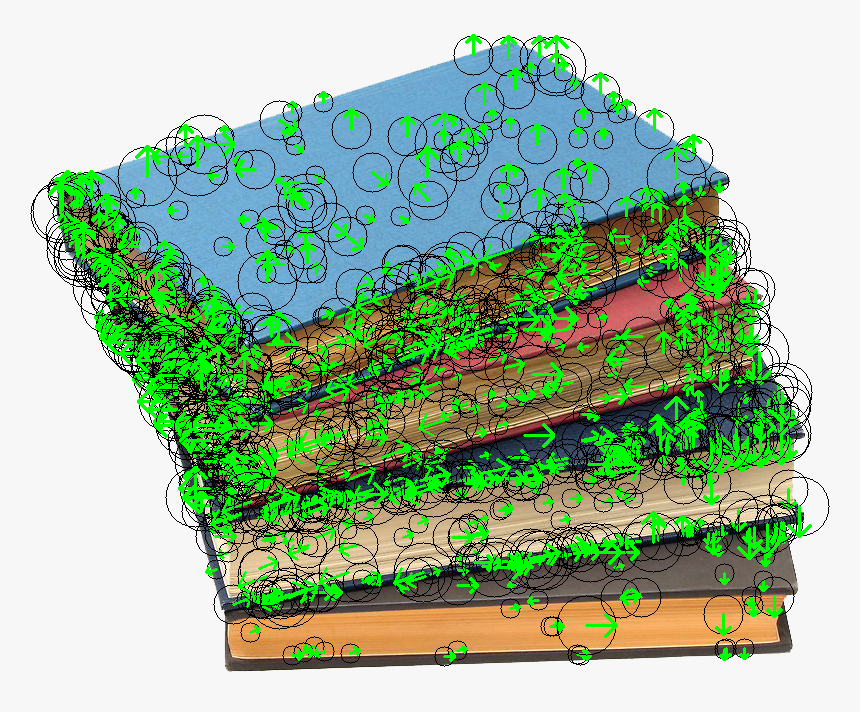

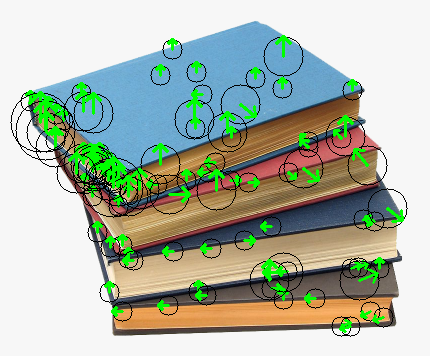

In [ ]:
display_keypoints(img2_cl,keypoints,False)

### Rotation

In [ ]:
angle = [30,45,60]
print(f'Image : 2\n\n')
for i,angle in enumerate(angle):
  print(f'Transformation: Rotation {angle} degrees')
  tempimg = rotate_image(img2,angle)
  tempkey = PCA_SIFT(tempimg,0.01)
  print(f'The number of Keypoints in 1st octave is {len(tempkey[0])}')
  print(f'The number of Keypoints in 2nd octave is {len(tempkey[1])}')
  print('\n')

Image : 2


Transformation: Rotation 30 degrees
The number of Keypoints in 1st octave is 997
The number of Keypoints in 2nd octave is 103


Transformation: Rotation 45 degrees
The number of Keypoints in 1st octave is 971
The number of Keypoints in 2nd octave is 62


Transformation: Rotation 60 degrees
The number of Keypoints in 1st octave is 872
The number of Keypoints in 2nd octave is 25




### Scaling

In [ ]:
angle = [1.25,1.5,2]
print(f'Image : 2\n\n')
for i,scale in enumerate(angle):
  print(f'Transformation: Scaling by {scale}')
  tempimg = scale_image(img2,scale)
  tempkey = PCA_SIFT(tempimg)
  print(f'The number of Keypoints in 1st octave is {len(tempkey[0])}')
  print(f'The number of Keypoints in 2nd octave is {len(tempkey[1])}')
  print('\n')

Image : 2


Transformation: Scaling by 1.25
The number of Keypoints in 1st octave is 971
The number of Keypoints in 2nd octave is 97


Transformation: Scaling by 1.5
The number of Keypoints in 1st octave is 2048
The number of Keypoints in 2nd octave is 120


Transformation: Scaling by 2
The number of Keypoints in 1st octave is 6224
The number of Keypoints in 2nd octave is 116




### Gaussian Blur

In [ ]:
sigma = [2,4,16]
print(f'Image : 2\n\n')
for i,sig in enumerate(sigma):
  print(f'Transformation: Gaussian blur, sigma = {sig}')
  tempimg = gaussian_blur(img2,sig)
  tempkey = PCA_SIFT(tempimg,0.005)
  print(f'The number of Keypoints in 1st octave is {len(tempkey[0])}')
  print(f'The number of Keypoints in 2nd octave is {len(tempkey[1])}')
  print('\n')

Image : 2


Transformation: Gaussian blur, sigma = 2
The number of Keypoints in 1st octave is 986
The number of Keypoints in 2nd octave is 1


Transformation: Gaussian blur, sigma = 4
The number of Keypoints in 1st octave is 815
The number of Keypoints in 2nd octave is 3


Transformation: Gaussian blur, sigma = 16
The number of Keypoints in 1st octave is 797
The number of Keypoints in 2nd octave is 5


